In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import os
os.environ["XLA_PYTHON_CLIENT_MEM_FRACTION"]=".4"

import time
import matplotlib.pyplot as plt
import matplotlib as mpl
import numpy as np
from copy import deepcopy

import jax
import jax.numpy as jnp
from jax import jit, lax, grad, value_and_grad, vmap
import optax
import distrax

from neuron import h
_ = h.load_file("stdlib.hoc")

from neurax.integrate import solve
from neurax.cell import Cell, _compute_num_kids, _compute_index_of_kid, compute_levels
from neurax.stimulus import Stimulus, step_current
from neurax.recording import Recording
from neurax.connection import Connection, Connectivity
from neurax.utils.plot_utils import plot_morph
from neurax.mechanisms.hh_neuron import hh_neuron_gate
from neurax.mechanisms.glutamate_synapse import glutamate

--No graphics will be displayed.


In [3]:
device_str = "gpu"
jax.config.update('jax_platform_name', device_str)

cpus = jax.devices("cpu")
gpus = jax.devices("gpu")

device = cpus[0] if device_str == "cpu" else gpus[0]

# Setup

### Define model

In [4]:
n_params_per_cell = 1

In [5]:
num_cells = 16
nseg_per_branch = 4
num_branches = 15
ncomp = num_branches * nseg_per_branch
parents = jnp.asarray([-1, 0, 0, 1, 1, 2, 2, 3, 3, 4, 4, 5, 5, 6, 6])

assert len(parents) == num_branches

# Initialize voltage
init_v = jnp.asarray([[-62.0] * num_branches*nseg_per_branch] * num_cells)

# Initialize states
init_m = jnp.asarray([[0.074901] * num_branches*nseg_per_branch] * num_cells)
init_h = jnp.asarray([[0.4889] * num_branches*nseg_per_branch] * num_cells)
init_n = jnp.asarray([[0.3644787] * num_branches*nseg_per_branch] * num_cells)
hh_states = jnp.stack([init_m, init_h, init_n])

length = 100.0  # um (length of a single branch)
radius = 10.0  # um
r_a = 10_000  # ohm cm 
i_delay = 5.0  # ms
i_amp = 1.0  # nA
i_dur = 2.0  # ms
dt = 0.025  # ms
t_max = 15.0  # ms

### Set up model

In [6]:
time_vec = jnp.arange(0, t_max+dt, dt)

In [7]:
cells = [Cell(num_branches, parents, nseg_per_branch, length, radius, r_a)] * num_cells
recs = [
    Recording(15, 0, 0.0),
]
conns = []
for pre in jnp.arange(5):
    for post in jnp.arange(5, 15):
        conn = Connection(pre, 0, 0.0, post, 7+pre, 1.0)
        conns.append(conn)
for pre in jnp.arange(5, 10):
    for post in jnp.arange(15, 16):
        conn = Connection(pre, 0, 0.0, post, 2+pre, 1.0)
        conns.append(conn)
for pre in jnp.arange(10, 15):
    for post in jnp.arange(15, 16):
        conn = Connection(pre, 0, 0.0, post, -3+pre, 0.5)
        conns.append(conn)
        
connectivities = [Connectivity(conns, nseg_per_branch),]

# Prepare stimuli.
stims = [
    Stimulus(
        cell_ind=i, 
        branch_ind=0, 
        loc=0.0, 
        current=step_current(i_delay, i_dur, i_amp, time_vec)
    ) for i in range(5)
]

### Define parameters

In [8]:
g_na = jnp.asarray([[0.12] * n_params_per_cell] * num_cells)
g_kd = jnp.asarray([[0.036] * n_params_per_cell] * num_cells)
g_leak = jnp.asarray([[0.0003] * n_params_per_cell] * num_cells)

theta_gt = jnp.stack([g_na, g_kd, g_leak])

synapse_params = jnp.asarray([1.0] * len(conns))
hh_params = jnp.tile(theta_gt, (1, 1, ncomp))

### ODE

In [9]:
mem_channels = [hh_neuron_gate,]
mem_states = [hh_states,]
mem_params = [hh_params,]

In [10]:
syn_channels = [glutamate,]
syn_states = [jnp.zeros((len(conns))),]
syn_params = [synapse_params,]

In [12]:
start_time = time.time()

# Solve ODE.
s = solve(
    cells,
    connectivities,
    init_v,
    mem_states=mem_states,
    mem_params=mem_params,
    mem_channels=mem_channels,
    syn_states=syn_states,
    syn_params=syn_params,
    syn_channels=syn_channels,
    stimuli=stims,
    recordings=recs,
    t_max=t_max,
    dt=dt,
    solver="stone",
    checkpoint_inds=[]
)
print("Time:  ", time.time() - start_time)

Time:   0.14133858680725098


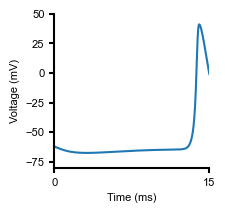

In [13]:
with mpl.rc_context(fname=".matplotlibrc"):
    fig, ax = plt.subplots(1, 1, figsize=(2, 2))
    _ = ax.plot(time_vec, s[0])
    _ = ax.set_ylim([-80, 50])
    ax.set_xlabel("")
    ax.set_xticks([])
    ax.set_xticks([0, max(time_vec)])
    ax.set_xlim([0, max(time_vec)])
    ax.set_xlabel("Time (ms)")
    ax.set_ylabel("Voltage (mV)")
    plt.subplots_adjust(hspace=0.4)
#     plt.savefig("../../results/response.png", dpi=200, bbox_inches="tight")
    plt.show()